In [1]:
import os

curr_folder = os.getcwd() + "/"
datasets_folder = curr_folder[:-6] + "Datasets/"
stats_results_folder = curr_folder + "Results/"
print(datasets_folder)
print(stats_results_folder)

/home/ipsilva/Repositories/dynamic-projections/Datasets/
/home/ipsilva/Repositories/dynamic-projections/Stats/Results/


In [2]:
datasets_subfolders = []
for i in os.walk(datasets_folder):
    datasets_subfolders.append(i[0])

datasets_subfolders = datasets_subfolders[1:]
datasets_subfolders

['/home/ipsilva/Repositories/dynamic-projections/Datasets/gaussians',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/quickdraw',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/sorts',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/walk',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/nnset',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/fashion',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/cifar10cnn',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/esc50',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/qtables',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/cartolastd']

In [3]:
dataset_number = 6
selected_dataset = datasets_subfolders[dataset_number]
selected_dataset

'/home/ipsilva/Repositories/dynamic-projections/Datasets/cifar10cnn'

In [4]:
from os import listdir
from os.path import isfile, join

files = [f for f in listdir(selected_dataset) if isfile(join(selected_dataset, f))]
files[:5]

['cifar10cnn-13.csv',
 'cifar10cnn-10.csv',
 'cifar10cnn-1.csv',
 'cifar10cnn-19.csv',
 'cifar10cnn-15.csv']

In [5]:
import pandas as pd
import numpy as np

df = pd.DataFrame()

obs_per_timestep = []
for file in files:
    file_loc = selected_dataset + "/" + file
    ndf = pd.read_csv(file_loc)
    df = df.append(ndf)
    obs_per_timestep.append(ndf.shape[0])
    
median_obs_per_timestep = np.median(obs_per_timestep)
dev_obs_per_timestep = np.std(obs_per_timestep)

df = df.drop(columns=df.columns[0], axis=1)
print(df.shape, df.head())

(30000, 10)          f0        f1        f2        f3        f4            f5        f6  \
0  0.010032  0.000353  0.049079  0.589695  0.011765  1.737237e-01  0.142289   
1  0.216628  0.069888  0.000191  0.000006  0.000010  2.390075e-07  0.000001   
2  0.146004  0.076302  0.003534  0.001641  0.000798  2.143449e-04  0.000436   
3  0.368393  0.019264  0.006644  0.000372  0.000928  2.537523e-05  0.000089   
4  0.000148  0.000288  0.063946  0.086240  0.499107  2.625506e-02  0.322843   

             f7        f8        f9  
0  3.916146e-03  0.018220  0.000927  
1  6.826322e-07  0.708683  0.004592  
2  3.172614e-04  0.733660  0.037093  
3  3.487493e-04  0.598512  0.005424  
4  8.312096e-04  0.000100  0.000241  


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def intrisic_dim(dataframe, target_variance):
    dataframe = StandardScaler().fit_transform(dataframe)
    pca = PCA()

    principalComponents = pca.fit_transform(dataframe)

    list_variance = pca.explained_variance_ratio_

    final_var = 0
    dims = 0
    for var in list_variance:
        final_var += var
        dims += 1
        if final_var > target_variance:
            break
    return dims, final_var, principalComponents[:dims]

In [7]:
target_variance = 0.9

(dims, final_var, components) = intrisic_dim(df, target_variance)

print("Total time-steps:", len(obs_per_timestep))
print("Registers per time-step (median):", median_obs_per_timestep)
print("Registers per time-step (deviation):", dev_obs_per_timestep)
print("Total dimensions:", df.shape[1])
print("Intrinsic dimensions:", dims)
print("Total variance:", final_var)

Total time-steps: 30
Registers per time-step (median): 1000.0
Registers per time-step (deviation): 0.0
Total dimensions: 10
Intrinsic dimensions: 8
Total variance: 0.9500292645836843


In [9]:
fig_name = selected_dataset.split('/')[-1]

0.8


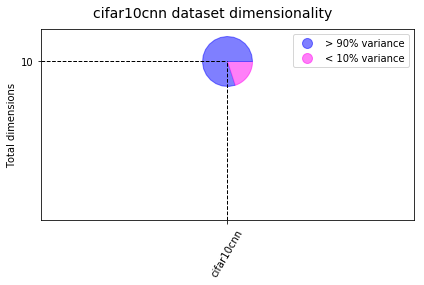

In [17]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

max_size = 50**2

fig, ax = plt.subplots(1,1)

ratio_intrinsic_dim = dims/df.shape[1]
size = max_size
greater_variance_color = [0,0,1,0.5]
complementary_variance_color = [1,0,0.95,0.5]

print(ratio_intrinsic_dim)

x = [0] + np.cos(np.linspace(0, 2 * np.pi * ratio_intrinsic_dim, 20)).tolist()
y = [0] + np.sin(np.linspace(0, 2 * np.pi * ratio_intrinsic_dim, 20)).tolist()
xy_instrinsic_dim = np.column_stack([x, y])

x = [0] + np.cos(np.linspace(2 * np.pi * ratio_intrinsic_dim, 2 * np.pi, 20)).tolist()
y = [0] + np.sin(np.linspace(2 * np.pi * ratio_intrinsic_dim, 2 * np.pi, 20)).tolist()
xy_total_dim = np.column_stack([x, y])

ax.scatter([fig_name], df.shape[1], marker=xy_total_dim,
           s=size, c=[complementary_variance_color])
ax.scatter([fig_name], df.shape[1], marker=xy_instrinsic_dim,
           s=size, c=[greater_variance_color])

legend_elements = (Line2D([0], [0], marker='o', color=greater_variance_color, lw=0, markersize=10, label='> 90% variance'),
                   Line2D([0], [0], marker='o', color=complementary_variance_color, lw=0, markersize=10, label='< 10% variance'))
leg = ax.legend(handles=legend_elements)

ax.set_ylabel('Total dimensions')
ax.yaxis.set_ticks([df.shape[1]])

lim_x = ax.set_xlim(fig_name, 5)
lim_x = ax.set_xlim(lim_x[0]-5, lim_x[1])

lim_y = ax.set_ylim(0, df.shape[1]+df.shape[1]*0.2)

ax.hlines([df.shape[1]], lim_x[0], fig_name, linestyle='--', lw=1)
ax.vlines([fig_name], lim_y[0], df.shape[1], linestyle='--', lw=1)

plt.xticks(rotation=60)

plt.suptitle(fig_name + " dataset dimensionality", fontsize=14, weight='roman')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.savefig(stats_results_folder+"dimensionality_plots/"+fig_name+"_dimensionality")

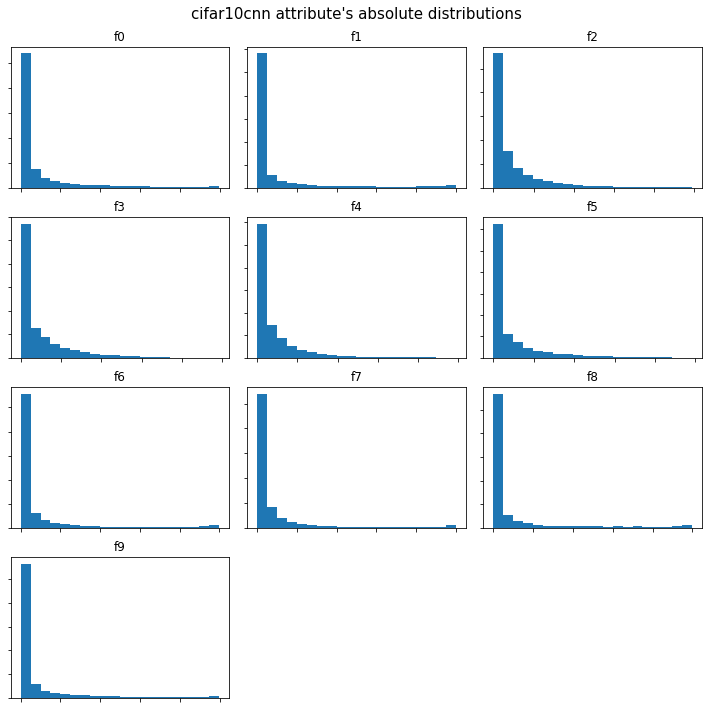

In [36]:
import matplotlib.pyplot as plt

# identifying distributions
hists_ax = df.hist(bins=20, grid=False, figsize=(10,10), density=True)

for arr in hists_ax:
    for ax in arr:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        
plt.suptitle(fig_name + " attribute's absolute distributions", fontsize=15, weight='roman')
plt.tight_layout()
plt.subplots_adjust(top=0.925)
plt.savefig(stats_results_folder+"attribute_histograms/"+fig_name+"_attr_dist")

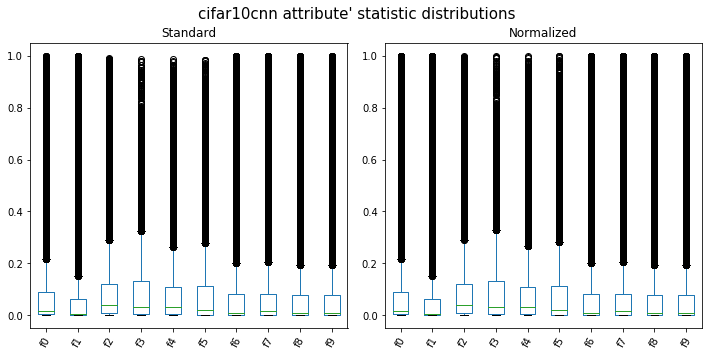

In [40]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax_box = df.plot.box(ax=axes[0])
ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=60);
ax_box.set_title("Standard")

min_max_scaler = MinMaxScaler()
ax_norm_box = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df)), columns=df.columns).plot.box(ax=axes[1])
ax_norm_box.set_xticklabels(ax_norm_box.get_xticklabels(), rotation=60);
ax_norm_box.set_title("Normalized");

plt.suptitle(fig_name + " attribute' statistic distributions", fontsize=15, weight='roman')
plt.tight_layout()
plt.subplots_adjust(top=0.88)

plt.savefig(stats_results_folder+"attribute_boxplots/"+fig_name+"_attr_statdist")